In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Kalman filter: quick recap

Watch the intro video: https://youtu.be/5Y-dnt2tNKY

Kalman filter (KF) is one of the most used state estimation algorithms in robotics applications. We may already know the motion model of a robot that allows us to know how the state of the robot evolves over time given its initial state. However, we always have to deal with imperfect motion model for various reasons (e.g., imperfect parts, etc.). Although robots typically have various sensors to also help in estimating the state of the robot, sensors are also noisy. With Kalman filter, we can combine the prediction from our motion model with the sensor measurement to get a better state estimate.

Remember the assumptions used in Kalman filter:
1. Linear dynamics with Gaussian noise $\mathbf{x}_{t} = A \mathbf{x}_{t-1} + B \mathbf{u}_{t-1} + \mathbf{w}_{t}$ where $\mathbf{w}_{t} \sim \mathcal{N}(0, Q)$
2. Linear measurement model with Gaussian noise $\mathbf{z}_t = H \mathbf{x}_t + \mathbf{n}_t$ where $\mathbf{n}_t \sim \mathcal{N}(0, R)$
3. Gaussian prior $bel(\mathbf{x}_0) \sim \mathcal{N}(\mu_0, \Sigma_0)$

In Kalman filter, there are two main steps that we need to perform. These are the prediction and update steps. We perform the prediction step to compute our new belief state after we apply a control signal $u_t$ to our robot following the motion model. After we apply a control signal $u_t$, we assume to have received a sensor measurement $z_t$, and we perform the update step to update the belief state based on the sensor measurement.

Prediction step:
1. $\mu_{t|t-1} = A\mu_{t-1|t-1} + B\mathbf{u}_{t-1}$
2. $\Sigma_{t|t-1} = A\Sigma_{t-1|t-1}A^T + Q$

Update step:
1. Get measurement $\mathbf{z}_{t}$
2. Compute mean and covariance of the prediction residual $\delta_{\mu} = \mathbf{z}_{t} - H\mu_{t|t-1}$ and $\delta_{\Sigma} = H \Sigma_{t|t-1} H^T + R$
3. Compute Kalman gain $K_{t} = \Sigma_{t|t-1} H^T \delta_{\Sigma}^{-1}$
4. Compute mean and covariance of the belief $\mu_{t | t} = \mu_{t | t-1} + K\delta_{\mu}$ and $\Sigma_{t | t} = \Sigma_{t|t-1} - KH\Sigma_{t|t-1}$

Let's take a look at a the example we discussed in the intro video.

**Example: estimating robot position with KF**

We have a robot moving in a room without obstacles that is equipped with sensors to measure distance between the robot and the walls, which allows the robot to measure the location of the robot  in the room (i.e., its $x$ and $y$ coordinates). For simplicity, let's assume we have a sensor that directly measure the $(x,y)$ location of the robot in the room. These sensors are not perfect, but we know how innacurate these sensors are (i.e., we know the measurement model). In addition, we also know the motion model of the robot. This means that we know the $A$, $B$, $Q$, $H$, and $R$ matrices:

$$
A = 
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

$$
B = 
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

$$
Q = 
\begin{bmatrix}
0.3 & 0 \\
0 & 0.3
\end{bmatrix}
$$

$$
H = 
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

$$
R = 
\begin{bmatrix}
0.75 & 0.0 \\
0.0 & 0.6
\end{bmatrix}
$$

The state of the robot is its $x$ and $y$ position in the room, and the control inputs are the velocity in each direction $v_x$ and $v_y$. The robot is initialized at $(x,y) = (0,0)$, and moves by applying constant control inputs $v_x = v_y = 1$ for 10 time steps. Assume the initial belief state as the following:

$$
\mu_0 = 
\begin{bmatrix}
0 \\
0
\end{bmatrix}
$$

$$
\Sigma_0 = 
\begin{bmatrix}
0.1 & 0\\
0 & 0.1
\end{bmatrix}
$$

Task: use Kalman filter to get a better estimate of where the robot is at each time step!

**Understanding the problem**

To understand the problem and motivate our desire to use Kalman filter, let's plot and compare the ideal trajectory with motion model trajectory as well as some possible measurements that we would get using the available sensors according to their specifications. Since we are not using an actual robot with a sensor, we will simulate the sensor measurements using the measurement model.

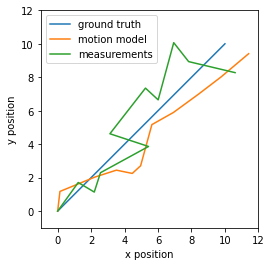

In [2]:
# state = [x_pos, y_pos]
num_steps = 10
ground_truth_xs = np.linspace(0, 10, num=num_steps + 1) # [0, 1, ..., 10]
ground_truth_ys = ground_truth_xs.copy() # x = y
ground_truth_states = np.stack((ground_truth_xs,ground_truth_ys), axis=1) # ground_truth_states is [[0,0], [1,1], ..., [10,10]]


# Simulate motion with our noisy motion model
x_0, y_0 = 0, 0 # given initial position at (0,0)
motion_states = [np.array([x_0, y_0])] # a list to store state at each step following noisy motion model
u_t = np.array([1.0, 1.0]) # given constant control input
A = np.array([[1, 0],
              [0, 1]])
B = np.array([[1, 0],
              [0, 1]])
Q = np.array([[0.3, 0],
              [0, 0.3]]) # given Q matrix
for _ in range(10):
    motion_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=Q) # ~N(0,Q)
    new_state = A @ motion_states[-1] + B @ u_t + motion_noise # note: a @ b = np.dot(a,b)
    motion_states.append(new_state)
    
    
# Simulate measurements with our noisy measurement model
# In real life, we are supposed to get these directly from our sensor
measurement_states = [np.array([x_0, y_0])] # # a list to store state at each step following noisy measurement model, assume we have perfect initial measurement
H = np.array([[1, 0],
              [0, 1]]) # given H matrix
R = np.array([[0.75, 0],
              [0, 0.6]]) # given R matrix
for i in range(10):
    measurement_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=R) # ~N(0,R)
    new_measurement = H @ ground_truth_states[i+1] + measurement_noise # this is z_t
    measurement_states.append(new_measurement)

    
# Convert motion_states and measurement_states to array so we can plot them easily
motion_states = np.array(motion_states)
measurement_states = np.array(measurement_states)


# Compare ground truth and measurements
plt.plot(ground_truth_states[:,0], ground_truth_states[:,1])
plt.plot(motion_states[:,0], motion_states[:,1])
plt.plot(measurement_states[:,0], measurement_states[:,1])
plt.xlim(-1,12)
plt.ylim(-1,12)
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend(['ground truth', 'motion model', 'measurements'])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

As we can see, estimating states using noisy motion model and sensor measurement alone produces noisy state estimates. With Kalman filter, we can get a better state estimates by combining the prediction from motion model and sensor measurements.

Let's implement the Kalman filter! Concretely, we just need to write two functions for the prediction and update steps, and to know when to call these functions.

**Prediction step**

Recall the prediction step:
1. $\mu_{t|t-1} = A\mu_{t-1|t-1} + B\mathbf{u}_{t-1}$
2. $\Sigma_{t|t-1} = A\Sigma_{t-1|t-1}A^T + Q$

In [3]:
def predict(A, B, Q, u_t, mu_t, Sigma_t):
    predicted_mu = A @ mu_t + B @ u_t
    predicted_Sigma = A @ Sigma_t @ A.T + Q
    return predicted_mu, predicted_Sigma

**Update step**

Recall the update step:
1. Get measurement $\mathbf{z}_{t}$
2. Compute mean and covariance of the prediction residual $\delta_{\mu} = \mathbf{z}_{t} - H\mu_{t|t-1}$ and $\delta_{\Sigma} = H \Sigma_{t|t-1} H^T + R$
3. Compute Kalman gain $K_{t} = \Sigma_{t|t-1} H^T \delta_{\Sigma}^{-1}$
4. Compute mean and covariance of the belief $\mu_{t | t} = \mu_{t | t-1} + K\delta_{\mu}$ and $\Sigma_{t | t} = \Sigma_{t|t-1} - KH\Sigma_{t|t-1}$

In [4]:
def update(H, R, z, predicted_mu, predicted_Sigma):
    residual_mean = z - H @ predicted_mu
    residual_covariance = H @ predicted_Sigma @ H.T + R
    kalman_gain = predicted_Sigma @ H.T @ np.linalg.inv(residual_covariance)
    updated_mu = predicted_mu + kalman_gain @ residual_mean
    updated_Sigma = predicted_Sigma - kalman_gain @ H @ predicted_Sigma
    return updated_mu, updated_Sigma

Let's now run our Kalman filter for 10 time steps!

In [5]:
# Re-initialize the problem with the given information
mu_0 = np.array([0, 0])
Sigma_0 = np.array([[0.1, 0],
                     [0, 0.1]])
u_t = np.array([1, 1]) # we assume constant control input

A = np.array([[1, 0],
              [0, 1]])
B = np.array([[1, 0],
              [0, 1]])
Q = np.array([[0.3, 0],
              [0, 0.3]])
H = np.array([[1, 0],
              [0, 1]])
R = np.array([[0.75, 0],
              [0, 0.6]])

# Initialize empty lists to store the filtered states and measurements for plotting
measurement_states = []
filtered_states = []

# Run KF for each time step
mu_current = mu_0.copy()
Sigma_current = Sigma_0.copy()
for i in range(num_steps):
    
    # Predict step
    predicted_mu, predicted_Sigma = predict(A, B, Q, u_t, mu_current, Sigma_current)
    
    # Get measurement (in real life, we get this from our sensor)    
    measurement_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=R) # ~N(0,R)
    new_measurement = H @ ground_truth_states[i+1] + measurement_noise # this is z_t
    
    # The rest of update step
    mu_current, Sigma_current = update(H, R, new_measurement, predicted_mu, predicted_Sigma)
    
    # Store measurements and mu_current so we can plot it later
    measurement_states.append(new_measurement)
    filtered_states.append(mu_current)

# For plotting purposes, convert the lists to array
measurement_states = np.array(measurement_states)
filtered_states = np.array(filtered_states) 

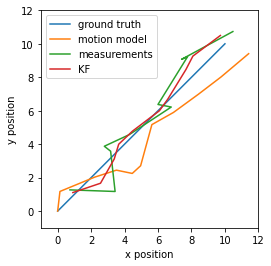

In [6]:
# Let's plot the results

plt.plot(ground_truth_states[:,0], ground_truth_states[:,1]) # from previous section
plt.plot(motion_states[:,0], motion_states[:,1]) # from previous section
plt.plot(measurement_states[:,0], measurement_states[:,1])
plt.plot(filtered_states[:,0], filtered_states[:,1])
plt.xlim(-1,12)
plt.ylim(-1,12)
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend(['ground truth', 'motion model', 'measurements', 'KF'])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

As we see above, the state estimation from using KF seems to be better compared to motion model and sensor measurement! I encourage you to copy this notebook and play around with all the parameters that may affect the performance of KF :)